In [1]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive/surely_not_sarcasm_data/'

Mounted at /content/drive


In [ ]:
!pip install contractions
!cp -r '$root/utils' .

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
import pickle

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Embedding, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Dropout, Bidirectional, BatchNormalization, LSTM, Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

from utils.preprocessing import tokenize, WordEmbeddings
from utils.evaluation import plot_history, evaluate, show_errors

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.2);

# prepare data

In [4]:
raw_data = pickle.load(open(root+'raw_data_2103', 'rb'))
data = pickle.load(open(root+'preprocessed_data_2103', 'rb'))

In [5]:
input_dim = 10000

In [6]:
tokenizers, tokenized_data = tokenize(data, input_dim, quantile=0.9, verbose=True)

X_train: maxlen = 22
X_train_par: maxlen = 57


In [7]:
maxlen = tokenized_data['X_train'].shape[1]
maxlen_parent = tokenized_data['X_train_par'].shape[1]

# attention + bi-LSTM + CNN
*Sarcasm Detection Using Soft Attention-Based  Bidirectional Long Short-Term Memory Model With Convolution Network*  
02.04.2022

In [8]:
vec_len = 200
emb_matrix_comment = WordEmbeddings().get_glove_embeddings(input_dim, vec_len, tokenizers['comment'], root=root)

coverage: 0.9815


In [13]:
input_layer =  keras.Input(shape=(maxlen,))

x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
            mask_zero=True, weights=[emb_matrix_comment], trainable=True,
            embeddings_regularizer=L1L2(l1=5e-6, l2=5e-6))(input_layer)

x = Bidirectional(LSTM(200, return_sequences=True, dropout=0.2), merge_mode=None)(x)
x = Attention()(x)

x = Conv1D(100, 3, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv1D(100, 3, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv1D(100, 3, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[input_layer], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(tokenized_data['X_train'], data['y_train'], epochs=50, batch_size=128, callbacks=[es],
                validation_data=(tokenized_data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 563s 93ms/step - loss: 1.2489 - accuracy: 0.6981 - val_loss: 0.6500 - val_accuracy: 0.7189
Epoch 2/50
6002/6002 [==============================] - 550s 92ms/step - loss: 0.6296 - accuracy: 0.7226 - val_loss: 0.6056 - val_accuracy: 0.7308
Epoch 3/50
6002/6002 [==============================] - 557s 93ms/step - loss: 0.6071 - accuracy: 0.7314 - val_loss: 0.6004 - val_accuracy: 0.7317
Epoch 4/50
6002/6002 [==============================] - 552s 92ms/step - loss: 0.6008 - accuracy: 0.7373 - val_loss: 0.5964 - val_accuracy: 0.7395
Epoch 5/50
6002/6002 [==============================] - 542s 90ms/step - loss: 0.5966 - accuracy: 0.7423 - val_loss: 0.5954 - val_accuracy: 0.7409
Epoch 6/50
6002/6002 [==============================] - 548s 91ms/step - loss: 0.5943 - accuracy: 0.7464 - val_loss: 0.5959 - val_accuracy: 0.7422
Epoch 7/50
6002/6002 [==============================] - 542s 90ms/step - loss: 0.5922 - accuracy: 0.7503 - val_loss: 0

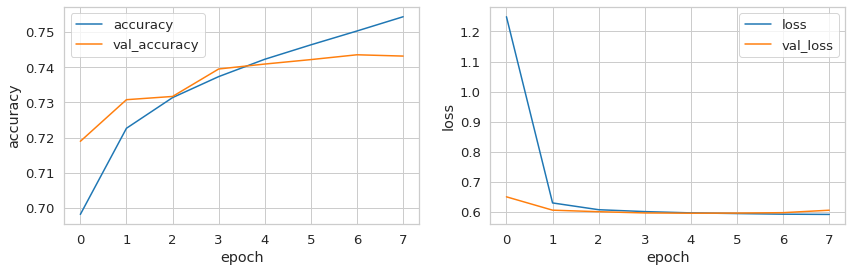

In [14]:
plot_history(fit)

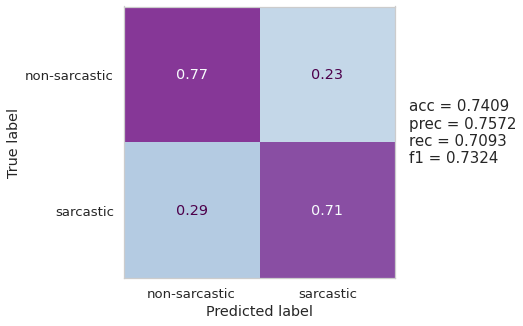

In [15]:
evaluate(model, tokenized_data['X_val'], data['y_val'])

In [16]:
model.save(root+'models/att_bilstm_cnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/att_bilstm_cnn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/att_bilstm_cnn/assets
